[[('Z', 0)], [('Z', 0), ('Z', 1)], [('Z', 2)], [('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 1)], [('Z', 0), ('Z', 2)], [('X', 0), ('X', 2), ('Z', 3)], [('X', 0), ('Z', 1), ('X', 2)], [('X', 0), ('Z', 1), ('X', 2), ('Z', 3)], [('X', 0), ('X', 2)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('Z', 2)], [('Z', 0), ('Z', 2), ('Z', 3)], [('Z', 1), ('Z', 3)]]
NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -0.8557807804833812
1 | Counter({('X', 'X', 'X', 'X'): 1}) | 1.0042192195166189
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8439551716824545
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.8377034838850317
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.8303485570645346
250 | Counter({('X', 'X', 'X', 'X'): 246, ('Z', 'Z', 'Z', 'Z'): 4}) | 0.02333651798333624
EXPERIMENT 0: GROUND STATE ENERGY FOUND = 

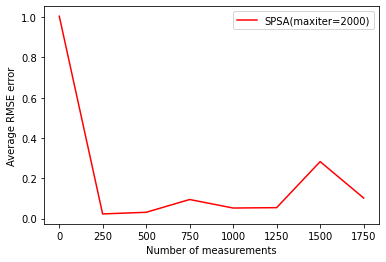

In [8]:
'''
EXPERIMENTS ON H2
'''

from qiskit_nature.second_q.mappers import BravyiKitaevMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
from collections import Counter
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp
from modified_derandomization import modified_derandomized_classical_shadow


# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 10

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86

# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
num_particles = problem.num_particles
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
# Note: the qubit order in Qiskit string is qn qn-1 ... q1 q0
# while in Qikit circuit it is              q0 q1 ... qn-1 qn  (little endian)
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)


hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_list = observable_str.split('*')
    pauli_str_list = [obs.replace(' ', '') for obs in observable_str_list]
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1][::-1]):  # reversing the order of single-qubit Paulis for Qiskit 
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])



hamiltonian_terms_XYZE = []

for term in hamiltonian_terms:
    term_XYZE = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZE.append(pauli)
    hamiltonian_terms_XYZE.append(term_XYZE)   
    

abs_weights = [abs(weight) for weight in weights]

hamiltonian_terms_XYZ = []
for idx, term in enumerate(hamiltonian_terms_XYZE):
    if term:
        hamiltonian_terms_XYZ.append(term)
    else:
        abs_weights.pop(idx)
        
print(hamiltonian_terms_XYZ)

reps = 1

ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)



backend = QasmSimulator(method='statevector', shots=1)


# Create circuit with just the randomised basis change operators
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.h(idx)
        elif op == 'Y':
            rand_meas.h(idx)
            rand_meas.p(-np.pi/2, idx)
        elif op == 'Z':
            rand_meas.id(idx)
    return rand_meas


def objective_function(operators, params):
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order qn qn-1 ... q1 q0

        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                snapshot.reverse()
                
                shadow.append(snapshot)
    
    
    cost = 0.0
    for term, weight in zip(hamiltonian_terms_XYZE, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost += weight * exp_val
            
        
    cost_history.append(cost)
    
    return cost



start_time = time.time()
rmse_errors = []


measurement_range = [1, 250, 500, 750, 1000, 1250, 1500, 1750]
print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    

    optimizer = SPSA(maxiter=2000)   
    expectation_values = []
    num_experiments = 3


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=2000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
/home/renata/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


[[('Z', 0)], [('Z', 0), ('Z', 1)], [('Z', 1)], [('Z', 2)], [('Z', 0), ('Z', 2)], [('X', 0), ('X', 2), ('Z', 3)], [('X', 0), ('Z', 1), ('X', 2)], [('X', 0), ('Z', 1), ('X', 2), ('Z', 3)], [('X', 0), ('X', 2)], [('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('Z', 2)], [('Z', 0), ('Z', 2), ('Z', 3)], [('Z', 1), ('Z', 3)]]
NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8354152336507379
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.837981353319902
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.8184644491495672
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.8317169329607743
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.8379947008574373
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.8306114470150454
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.8190038445848964
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -1.8370601150317951
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -1.8083174804428543
EXPERIM

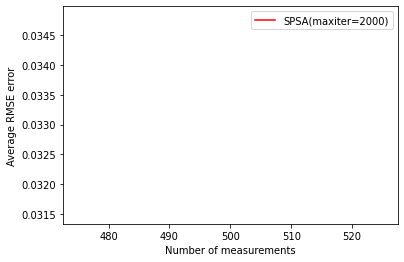

In [1]:
'''
EXPERIMENTS ON H2
'''

from qiskit_nature.second_q.mappers import BravyiKitaevMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
from collections import Counter
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp
from modified_derandomization import modified_derandomized_classical_shadow


# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 10

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86

# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
num_particles = problem.num_particles
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
# Note: the qubit order in Qiskit string is qn qn-1 ... q1 q0
# while in Qikit circuit it is              q0 q1 ... qn-1 qn  (little endian)
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)


hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_list = observable_str.split('*')
    pauli_str_list = [obs.replace(' ', '') for obs in observable_str_list]
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1][::-1]):  # reversing the order of single-qubit Paulis for Qiskit 
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])



hamiltonian_terms_XYZE = []

for term in hamiltonian_terms:
    term_XYZE = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZE.append(pauli)
    hamiltonian_terms_XYZE.append(term_XYZE)   
    

abs_weights = [abs(weight) for weight in weights]

hamiltonian_terms_XYZ = []
for idx, term in enumerate(hamiltonian_terms_XYZE):
    if term:
        hamiltonian_terms_XYZ.append(term)
    else:
        abs_weights.pop(idx)
        
print(hamiltonian_terms_XYZ)

reps = 1

ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)



backend = QasmSimulator(method='statevector', shots=1)


# Create circuit with just the randomised basis change operators
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.h(idx)
        elif op == 'Y':
            rand_meas.h(idx)
            rand_meas.p(-np.pi/2, idx)
        elif op == 'Z':
            rand_meas.id(idx)
    return rand_meas


def objective_function(operators, params):
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order qn qn-1 ... q1 q0

        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                snapshot.reverse()
                
                shadow.append(snapshot)
    
    
    cost = 0.0
    for term, weight in zip(hamiltonian_terms_XYZE, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost += weight * exp_val
            
        
    cost_history.append(cost)
    
    return cost



start_time = time.time()
rmse_errors = []


measurement_range = [500] #[1, 250, 500, 750, 1000, 1250, 1500, 1750]
print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    

    optimizer = SPSA(maxiter=2000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=2000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

In [ ]:
-1.86